# Demo - Bayesian Neural Network Regression

In [1]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Generate Sample Data

In [3]:
import math

In [17]:
torch.manual_seed(42)
np.random.seed(42)

# Generate random points
num_points_per_range = 100
range1_points = np.random.uniform(0, 1, num_points_per_range)

# Add Gaussian noise with mean 0 and std dev 0.1
noise_sd = 0.01

x=torch.tensor(np.sort(np.concatenate([range1_points])).astype(np.float32))


print("Concatenated  Points:", x)


Concatenated  Points: tensor([-0.7876, -0.7651, -0.7064, -0.7064, -0.6909, -0.6900, -0.6726, -0.5753,
        -0.4408, -0.4393, -0.3752, -0.3608, -0.3005, -0.2803, -0.2296, -0.2181,
         0.2279,  0.2837,  0.3023,  0.3198,  0.3747,  0.3753,  0.3825,  0.4198,
         0.4592,  0.4736,  0.5085,  0.5149,  0.5554,  0.5645,  0.5671,  0.6711])


In [18]:
y_l = torch.sin(8 *np.pi* x)
x_hf_true=np.linspace(0,1,100)
y_hf_true=(x_hf_true-np.sqrt(2))*(np.sin(8*np.pi*x_hf_true)**2)
x_hf=np.linspace(0,1,14).astype(np.float32)
y_hf=(x_hf-np.sqrt(2))*(np.sin(8*np.pi*x_hf)**2)+np.random.normal(loc=0, scale=0.01, size=14).astype(np.float32)

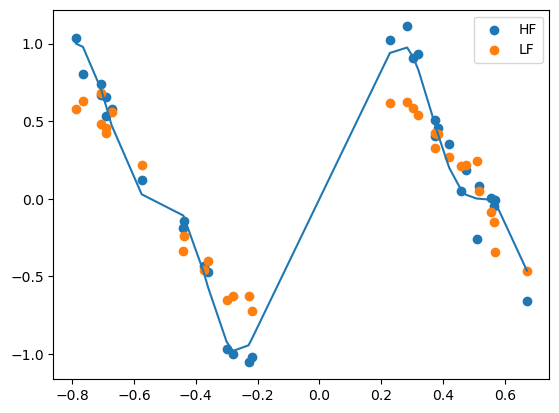

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate sin(8x)
y = np.sin(8 * np.pi * x)

# Plot the curve
plt.plot(x, y,label='LF')
plt.title('Plot of sin(8x)')
plt.xlabel('x')
plt.ylabel('sin(8x)')
plt.grid(True)
plt.plot(x_hf_true,y_hf_true,label='HF_True')
plt.scatter(x_hf,y_hf,label='HF Data',color='red')
plt.legend()
plt.show()

## Torch Bnn Implementation

## 2. Define Model

In [37]:
x_h,y_h=np.load('x,y 2024 05 15 _ 15  01  40----HF.npy')
indices = np.arange(100)
np.random.shuffle(indices)
x_h,y_h=x_h[indices][:70,:],y_h[indices][:70,:]

In [38]:
x=torch.tensor(x_h)
y=torch.tensor(y_h)

In [39]:
pretrained_weights = torch.load('MODEL 2024 05 15 _ 16  04  54----LF.pth')

In [40]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=1, out_features=50),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=50, out_features=50),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=50, out_features=1)
    
)

In [41]:
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [42]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: 0.weight_mu, Requires Gradient: True
Layer: 0.weight_log_sigma, Requires Gradient: True
Layer: 0.bias_mu, Requires Gradient: True
Layer: 0.bias_log_sigma, Requires Gradient: True
Layer: 2.weight_mu, Requires Gradient: True
Layer: 2.weight_log_sigma, Requires Gradient: True
Layer: 2.bias_mu, Requires Gradient: True
Layer: 2.bias_log_sigma, Requires Gradient: True
Layer: 4.weight_mu, Requires Gradient: True
Layer: 4.weight_log_sigma, Requires Gradient: True
Layer: 4.bias_mu, Requires Gradient: True
Layer: 4.bias_log_sigma, Requires Gradient: True


In [43]:
for param in model[0].parameters():
    param.requires_grad = False


In [44]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: 0.weight_mu, Requires Gradient: False
Layer: 0.weight_log_sigma, Requires Gradient: False
Layer: 0.bias_mu, Requires Gradient: False
Layer: 0.bias_log_sigma, Requires Gradient: False
Layer: 2.weight_mu, Requires Gradient: True
Layer: 2.weight_log_sigma, Requires Gradient: True
Layer: 2.bias_mu, Requires Gradient: True
Layer: 2.bias_log_sigma, Requires Gradient: True
Layer: 4.weight_mu, Requires Gradient: True
Layer: 4.weight_log_sigma, Requires Gradient: True
Layer: 4.bias_mu, Requires Gradient: True
Layer: 4.bias_log_sigma, Requires Gradient: True


In [45]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 1
ler=0.001
optimizer = optim.Adam(model.parameters(), lr=ler)

## 3. Train Model

In [46]:
mse_losses=[]
kl_losses=[]
iterations=500000

In [47]:
for step in range(iterations):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*(kl/ x.shape[0])
    mse_losses.append(mse.item())
    kl_losses.append(kl.item())

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.00, KL : 1.04


## 4. Test Model

In [57]:
x_test= np.random.uniform(0, 1, 1000)
x_test = torch.tensor(np.sort(x_test), dtype=torch.float32)
y_test =(x_test-np.sqrt(2))*(np.sin(8*np.pi*x_test)**2)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

x_exact=np.linspace(0,1,1000)
y_exact=(x_exact-np.sqrt(2))*(np.sin(8*np.pi*x_exact)**2)


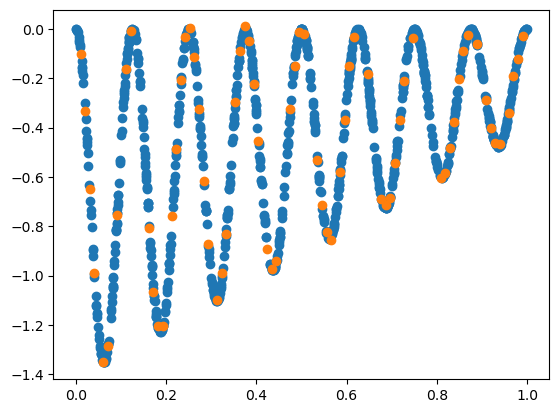

In [58]:
plt.scatter(x_test,y_test)
plt.scatter(x_h,y_h)

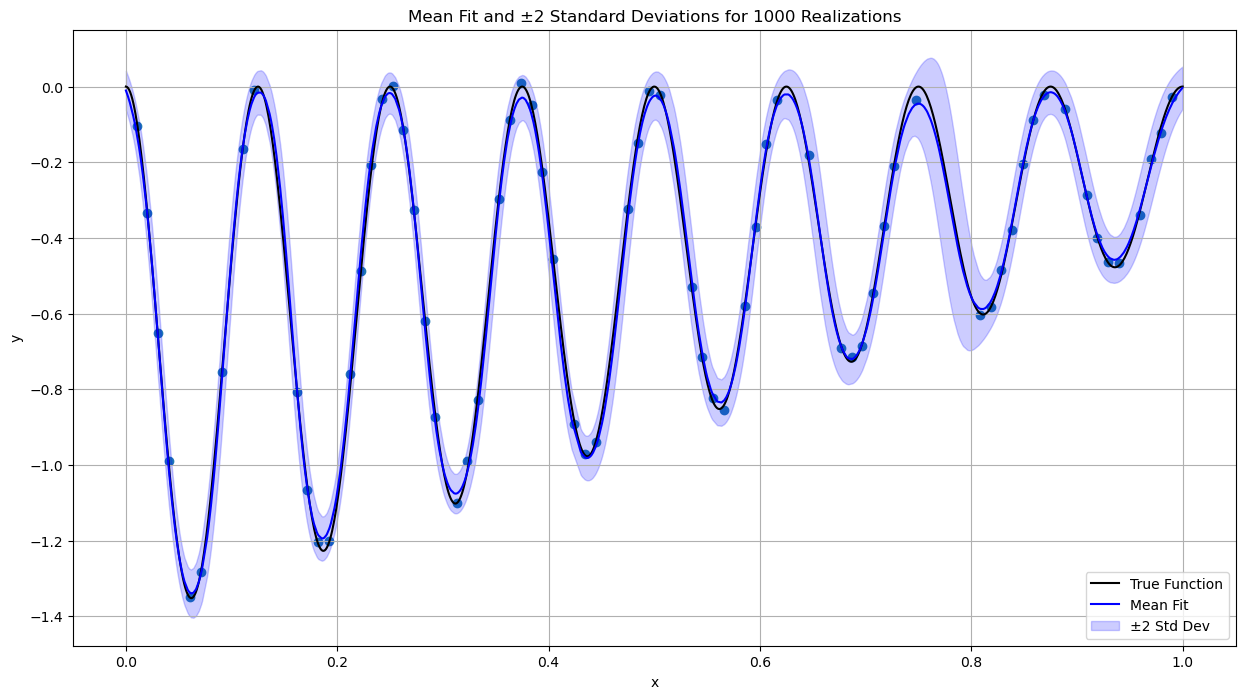

In [59]:
num_realizations = 1000
all_fits = []
for _ in range(num_realizations):
    fit = model(x_test)
    all_fits.append(fit.data.numpy())


all_fits = np.array(all_fits)


mean_fit = np.mean(all_fits, axis=0)
std_fit = np.std(all_fits, axis=0)
meanplus=mean_fit+ 2*std_fit
meanminus=mean_fit-2*std_fit


plt.figure(figsize=(15, 8))
plt.scatter(x.data.numpy(),y.data.numpy())
plt.plot(x_exact, y_exact, label='True Function', color='black')
plt.plot(x_test, mean_fit, label='Mean Fit', color='blue')

plt.fill_between(x_test.data.numpy().squeeze(), (mean_fit - 2 * std_fit).squeeze(), (mean_fit + 2 * std_fit).squeeze(), color='blue', alpha=0.2, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mean Fit and ±2 Standard Deviations for 1000 Realizations')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
def save_results_to_word(params, mse_loss, kl_loss,model,x,y):
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y %m %d _ %H  %M  %S")
    torch.save(model.state_dict(),'MODEL {}----MF.pth'.format(timestamp) )
    # Generate and save an example plot
    num_realizations = 1000
    all_fits = []
    for _ in range(num_realizations):
        fit = model(x_test)
        all_fits.append(fit.data.numpy())
    
    all_fits = np.array(all_fits)
    

    
    mean_fit = np.mean(all_fits, axis=0)
    std_fit = np.std(all_fits, axis=0)
    l2_norm=np.linalg.norm(mean_fit-np.array(y_test))
    normalized_l2_norm=l2_norm/(np.linalg.norm(np.array(y_test)))


    
    print(" MEAN VALIDATION ERROR-----{}".format(normalized_l2_norm))
    np.save('x,y {}----MF'.format(timestamp),[x,y])
    


    np.save('mean_fit {}----MF'.format(timestamp),mean_fit)
    np.save('sd_fit {}-----MF'.format(timestamp),std_fit)
    
    meanplus=mean_fit+ 2*std_fit
    meanminus=mean_fit-2*std_fit
    
    
    plt.figure(figsize=(8, 5))
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x_exact, y_exact, label='True Function', color='black')
    plt.plot(x_test, mean_fit, label='Mean Fit', color='blue') 
    
    plt.fill_between(x_test.data.numpy().squeeze(), (mean_fit - 2 * std_fit).squeeze(), (mean_fit + 2 * std_fit).squeeze(), color='blue', alpha=0.2, label='±2 Std Dev')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mean Fit and ±2 Standard Deviations for 1000 Realizations{}'.format(timestamp))
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
              
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Plot MSE losses
    ax1.plot(mse_loss, color='blue', label='MSE Loss {}'.format(timestamp))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('MSE Loss')
    ax1.legend()
    
    # Plot KL losses
    ax2.plot(kl_loss, color='red', label='KL Loss {}'.format(timestamp))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('KL Loss')
    ax2.set_title('KL Loss')
    ax2.legend()

    np.save('kl_losses {}----MF'.format(timestamp),kl_loss)
    np.save('mse_losses {}-----MF'.format(timestamp),mse_loss)
    
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    print(params)
    print(timestamp)



In [61]:
bnn_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 0.5,
}

In [62]:
bnn_parameters['learning_rate']=ler
bnn_parameters['kl weight']=kl_weight
bnn_parameters['layers']=['50 , 50,50']
bnn_parameters['Optimizer']=optimizer
bnn_parameters['min_mse']=min(mse_losses)
bnn_parameters['min_kl']=min(kl_losses)
bnn_parameters['iterations']=iterations

 MEAN VALIDATION ERROR-----0.03824358433485031


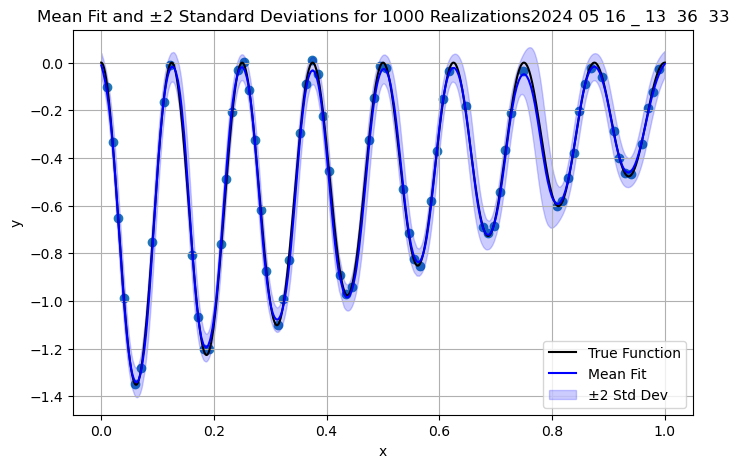

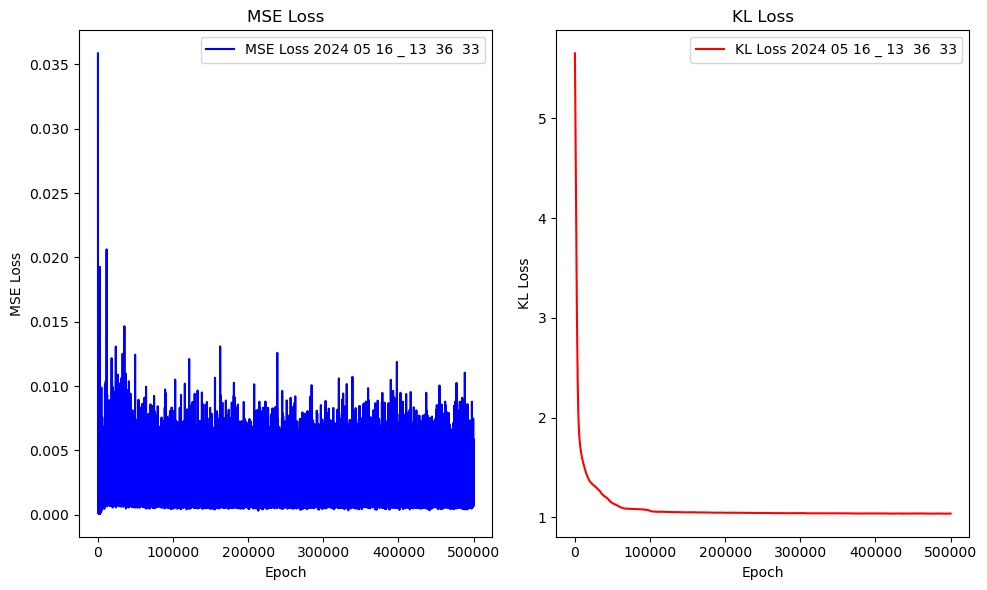

{'prior_mu': 0.0, 'prior_sigma': 0.5, 'learning_rate': 0.001, 'kl weight': 1, 'layers': ['50 , 50,50'], 'Optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'min_mse': 8.80936422618106e-05, 'min_kl': 1.0371159315109253, 'iterations': 500000}
2024 05 16 _ 13  36  33


In [63]:
save_results_to_word(bnn_parameters, mse_losses, kl_losses,model,x,y)

# Using Intel Lab

### Bringing in Hf and LF data

In [59]:
x_h,y_h=np.load('x,y 2024 05 15 _ 10  24  37----HF.npy')
indices = np.arange(100)
np.random.shuffle(indices)
x_h,y_h=x_h[indices][:100,:],y_h[indices][:100,:]

In [60]:
x=torch.tensor(x_h)
y=torch.tensor(y_h)

In [61]:
x.shape

torch.Size([100, 1])

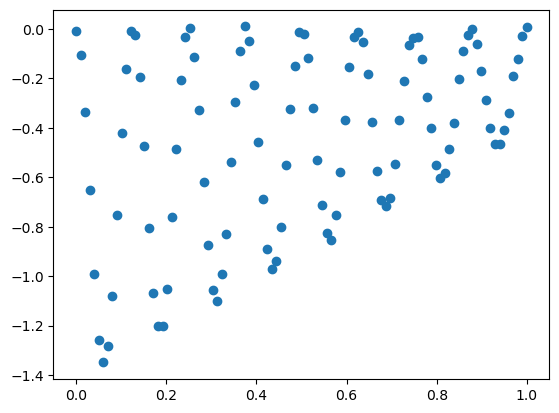

In [62]:
plt.scatter(x,y)

### Bringing in LF model weights

In [7]:
pretrained_weights = torch.load('MODEL 2024 05 15 _ 10  25  27----LF.pth')

In [63]:
import torch
import torchvision
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt


In [64]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=50),  # First hidden layer with 50 units
    nn.Tanh(),  # ReLU activation function
    nn.Linear(in_features=50, out_features=50),  # Second hidden layer with 50 units
    nn.Tanh(),  # ReLU activation function
    nn.Linear(in_features=50, out_features=1)  # Output layer
)

In [65]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=50),  # First hidden layer with 50 units
    #nn.Dropout(p=0.5),  # Dropout layer with probability 0.5
    nn.Tanh(),  # Tanh activation function
    nn.Linear(in_features=50, out_features=50),  # Second hidden layer with 50 units
    nn.Tanh(),  # Tanh activation function
    nn.Linear(in_features=50, out_features=50), # Output layer
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1)
    
)

In [66]:
bnn_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.2,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

In [67]:
dnn_to_bnn(model, bnn_parameters)

In [58]:
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [68]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: 0.mu_weight, Requires Gradient: True
Layer: 0.rho_weight, Requires Gradient: True
Layer: 0.mu_bias, Requires Gradient: True
Layer: 0.rho_bias, Requires Gradient: True
Layer: 2.mu_weight, Requires Gradient: True
Layer: 2.rho_weight, Requires Gradient: True
Layer: 2.mu_bias, Requires Gradient: True
Layer: 2.rho_bias, Requires Gradient: True
Layer: 4.mu_weight, Requires Gradient: True
Layer: 4.rho_weight, Requires Gradient: True
Layer: 4.mu_bias, Requires Gradient: True
Layer: 4.rho_bias, Requires Gradient: True
Layer: 6.mu_weight, Requires Gradient: True
Layer: 6.rho_weight, Requires Gradient: True
Layer: 6.mu_bias, Requires Gradient: True
Layer: 6.rho_bias, Requires Gradient: True


In [15]:
for param in model[0].parameters():
    param.requires_grad = False


In [334]:
for param in model[2].parameters():
    param.requires_grad=False

In [69]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: 0.mu_weight, Requires Gradient: True
Layer: 0.rho_weight, Requires Gradient: True
Layer: 0.mu_bias, Requires Gradient: True
Layer: 0.rho_bias, Requires Gradient: True
Layer: 2.mu_weight, Requires Gradient: True
Layer: 2.rho_weight, Requires Gradient: True
Layer: 2.mu_bias, Requires Gradient: True
Layer: 2.rho_bias, Requires Gradient: True
Layer: 4.mu_weight, Requires Gradient: True
Layer: 4.rho_weight, Requires Gradient: True
Layer: 4.mu_bias, Requires Gradient: True
Layer: 4.rho_bias, Requires Gradient: True
Layer: 6.mu_weight, Requires Gradient: True
Layer: 6.rho_weight, Requires Gradient: True
Layer: 6.mu_bias, Requires Gradient: True
Layer: 6.rho_bias, Requires Gradient: True


In [70]:
kl_losses=[]
mse_losses=[]
ler=0.00001
kl_weight=0.01
iterations=500000
Optimizer = torch.optim.Adam(model.parameters(), lr=ler)

In [71]:
for step in range(iterations):
    criterion = torch.nn.MSELoss()
    optimizer = Optimizer
    kl = get_kl_loss(model)
    ce_loss = criterion(model(x), y)
    loss = ce_loss + (kl/ x.shape[0])*kl_weight 
    
    mse_losses.append(ce_loss.item())
    kl_losses.append(kl.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

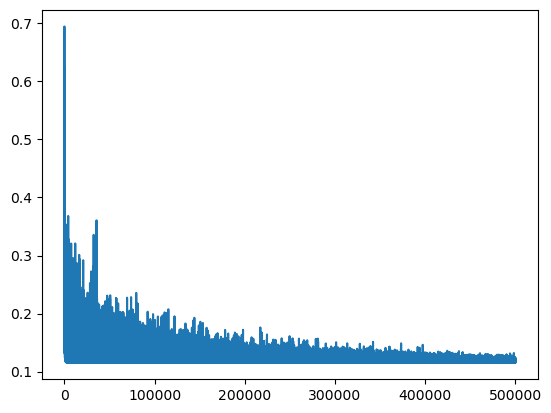

In [72]:
plt.plot(mse_losses)

In [73]:
def save_results_to_word(params, mse_loss, kl_loss,model,x,y):
    timestamp = datetime.datetime.now().strftime("%Y %m %d _ %H  %M  %S")
    torch.save(model.state_dict(),'MODEL {}----MF.pth'.format(timestamp) )
    # Generate and save an example plot
    num_realizations = 1000
    all_fits = []
    for _ in range(num_realizations):
        fit = model(x_test)
        all_fits.append(fit.data.numpy())
    
    all_fits = np.array(all_fits)
    

    
    mean_fit = np.mean(all_fits, axis=0)
    std_fit = np.std(all_fits, axis=0)
    l2_norm=np.linalg.norm(mean_fit-np.array(y_test))
    normalized_l2_norm=l2_norm/(np.linalg.norm(np.array(y_test)))


    
    print(" MEAN VALIDATION ERROR-----{}".format(normalized_l2_norm))
    np.save('x,y {}----MF'.format(timestamp),[x,y])
    


    np.save('mean_fit {}----MF'.format(timestamp),mean_fit)
    np.save('sd_fit {}-----MF'.format(timestamp),std_fit)
    
    meanplus=mean_fit+ 2*std_fit
    meanminus=mean_fit-2*std_fit
    
    
    plt.figure(figsize=(8, 5))
    plt.scatter(x.data.numpy(),y.data.numpy())
    plt.plot(x_exact, y_exact, label='True Function', color='black')
    plt.plot(x_test, mean_fit, label='Mean Fit', color='blue') 
    
    plt.fill_between(x_test.data.numpy().squeeze(), (mean_fit - 2 * std_fit).squeeze(), (mean_fit + 2 * std_fit).squeeze(), color='blue', alpha=0.2, label='±2 Std Dev')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mean Fit and ±2 Standard Deviations for 1000 Realizations{}'.format(timestamp))
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
              
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Plot MSE losses
    ax1.plot(mse_loss, color='blue', label='MSE Loss {}'.format(timestamp))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('MSE Loss')
    ax1.legend()
    
    # Plot KL losses
    ax2.plot(kl_loss, color='red', label='KL Loss {}'.format(timestamp))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('KL Loss')
    ax2.set_title('KL Loss')
    ax2.legend()

    np.save('kl_losses {}----MF'.format(timestamp),kl_loss)
    np.save('mse_losses {}-----MF'.format(timestamp),mse_loss)
    
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    print(params)
    print(timestamp)



In [47]:
bnn_parameters['learning_rate']=ler
bnn_parameters['kl weight']=kl_weight
bnn_parameters['layers']=['50 , 50,50']
bnn_parameters['Optimizer']=Optimizer
bnn_parameters['min_mse']=min(mse_losses)
bnn_parameters['min_kl']=min(kl_losses)
bnn_parameters['iterations']=iterations

In [48]:
x_test= np.random.uniform(0, 1, 100)
x_test = torch.tensor(np.sort(x_test), dtype=torch.float32)
y_test = (x_test-np.sqrt(2))*(np.sin(8*np.pi*x_test)**2)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

x_exact=np.linspace(0,1,100)
y_exact=(x_exact-np.sqrt(2))*(np.sin(8*np.pi*x_exact)**2)


 MEAN VALIDATION ERROR-----0.03200579434633255


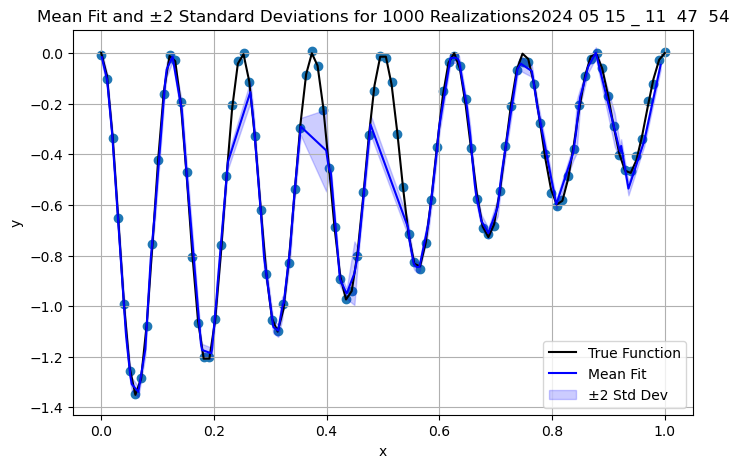

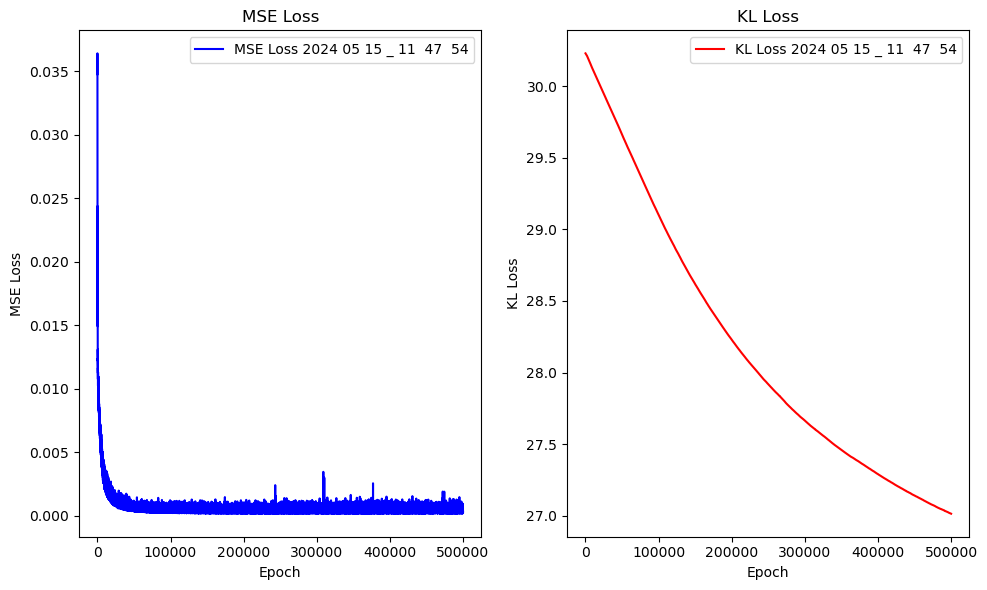

{'prior_mu': 0.0, 'prior_sigma': 1.2, 'posterior_mu_init': 0.0, 'posterior_rho_init': 0.0, 'type': 'Reparameterization', 'moped_enable': True, 'moped_delta': 0.5, 'learning_rate': 1e-05, 'kl weight': 0.01, 'layers': ['50 , 50,50'], 'Optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
), 'min_mse': 0.00017003135872073472, 'min_kl': 27.013710021972656, 'iterations': 500000}
2024 05 15 _ 11  47  54


In [49]:
save_results_to_word(bnn_parameters, mse_losses, kl_losses,model,x,y)

(2, 32, 1)